In [1]:
import ee
import pandas as pd
from tqdm.auto import tqdm
import plotnine
from plotnine import *
from dfply import *

In [2]:
# authenticate earthengine api
ee.Initialize()

In [3]:
from Modules.Modules import filter_exclude, get_img_df, compute_mean_ci
from Modules.Parallize_df import parallelize_dataframe

# might need reload modules as the code progrocessing
%load_ext autoreload
%autoreload 2

In [4]:
# import GAEZ data from ee_asset
GAEZ_list = ! earthengine ls users/wangjinzhulala/Paper_3/03_GAEZ

# get the admin shp
NCP_provinces = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Boundary_shp/North_China_Plain_province_boundry")

# get the GAEZ pixel size
GAEZ_pix_scale = ee.Image("users/wangjinzhulala/Paper_3/03_GAEZ/GAEZ_2_Moisture_Annual_P_PET_1981_2010_Historical").projection().nominalScale().getInfo()

In [5]:
# pair Chinese city names with english spelling
city_cn_en = dict(zip(['北京市','天津市', '河北省','江苏省', '安徽省', '河南省', '山东省'],
                      ['Beijing','Tianjin', 'Hebei','Jiangsu', 'Anhui', 'Henan', 'Shandong']))

### Compute the difference between GAEZ_yield and yearbook_yield records

In [6]:
# read data
crop_yield_history_1975_2020 = pd.read_csv('./result_csv/crop_yield_history_1975_2020.csv')
GYGA_weighted_by_area_ratio = pd.read_csv('./result_csv/GYGA_weighted_by_area_ratio.csv')

GAEZ_attainable_t_ha_forced_with_GYGA = pd.read_pickle('./result_csv/GAEZ_attainable_t_ha_forced_with_GYGA.pkl')
GAEZ_attainable_t_ha_forced_with_GYGA_weighted_mean_mul = pd.read_csv('./result_csv/GAEZ_attainable_t_ha_forced_with_GYGA_weighted_mean_mul.csv')

#### Plot the original value to see the difference 

In [21]:
# Get the GAEZ attainable yield for 2020
GAEZ_attainable_t_ha_forced_with_GYGA = pd.read_pickle('./result_csv/GAEZ_attainable_t_ha_forced_with_GYGA.pkl')
GAEZ_attainable_t_ha_forced_with_GYGA_2020 = GAEZ_attainable_t_ha_forced_with_GYGA.query('year == 2020')

In [23]:
# # get the actual GAEZ crop yield (t) with water supply in 2010
# GAEZ_yield_2010 = get_img_df(img_path = GAEZ_list,
#                 theme = 'GAEZ_5',
#                 variable = 'Yield',
#                 time = '2010',
#                 crop = ['Maize','Wetland_rice','Wheat'],
#                 water = ['Irrigated','Rainfed'])

# # formatting and add infos
# GAEZ_yield_2010['image'] = GAEZ_yield_2010['GEE_path'].apply(lambda x:ee.Image(x))
# GAEZ_yield_2010 = GAEZ_yield_2010.rename(columns={'time':'year'})
# GAEZ_yield_2010 = GAEZ_yield_2010.drop(columns='GEE_path')
# GAEZ_yield_2010['rcp'] = 'GAEZ_actual'
# GAEZ_yield_2010

In [24]:
def compute_area_weighted_mean(df):

  ##################### Multiply each crop_water with its area_ratio #############
  # read the harvested area ratio so we can compute the weigted mean attainable yield
  area_ratio = pd.read_pickle('./result_csv/harvested_area_ratio.pkl')
  df = df.merge(area_ratio,on=['crop','water'])

  # compute the area_weighted actual yield
  df['val_area_weighted'] = df.apply(lambda x:x['image'].multiply(x['area_ratio']),1)

  ##################### Sum the area_weighted yield #############
  stats_dict = {}
  for idx,df in df.groupby(['crop','year','rcp']):

    img_val = ee.ImageCollection(df['val_area_weighted'].tolist()).sum()

    stats_dict[idx] = {'img_val':img_val}

  ##################### make the stats a sensibel df #############
  out_df = pd.DataFrame(stats_dict).T.reset_index()
  out_df = out_df.rename(columns={'level_0':'crop','level_1':'year','level_2':'rcp'})

  return out_df

In [26]:
# function to get attianable yield for each province
def compute_yield_each_province(in_df):

  # hack to show progress bar
  print(' ',end='',flush=True)

  df_list = []

  # compute the attainable yield in each provinces
  for idx,row in tqdm(in_df.iterrows(),total=len(in_df)):
    crop = row['crop']
    year = row['year']
    rcp = row['rcp']

    img = row['img_val'].toFloat()

    # compute stats from GEE
    stats = img.reduceRegions(collection=NCP_provinces,reducer='mean',scale=GAEZ_pix_scale).getInfo()

    # get data
    stats_df = pd.DataFrame({i['properties']['EN_Name']:[i['properties']['mean']] for i in stats['features']}).T

    # append infomation
    stats_df = stats_df.reset_index()
    stats_df.columns=['Province','Mean Production']
    stats_df['crop'] = crop
    stats_df['year'] = year
    stats_df['rcp'] = rcp
    
    # store df                        
    df_list.append(stats_df)

  # concat dfs
  out_df = pd.concat(df_list,ignore_index=True)
  
  return out_df

In [30]:
# 1) first get area_weighted mean attainable yield (t/ha)
GAEZ_yield_2020_area_weighted_mean = compute_area_weighted_mean(GAEZ_attainable_t_ha_forced_with_GYGA_2020)

# 2) then get mean attainable yield (t/ha) in each province
GAEZ_yield_2020_area_weighted_mean_each_province = parallelize_dataframe(GAEZ_yield_2020_area_weighted_mean,compute_yield_each_province,3)

# 3) extend the year column for plot making
GAEZ_yield_2020_area_weighted_mean_each_province_for_plot = GAEZ_yield_2020_area_weighted_mean_each_province.copy()
GAEZ_yield_2020_area_weighted_mean_each_province_for_plot['year'] = [[2015,2025]]*len(GAEZ_yield_2020_area_weighted_mean_each_province_for_plot)
GAEZ_yield_2020_area_weighted_mean_each_province_for_plot = GAEZ_yield_2020_area_weighted_mean_each_province_for_plot.explode('year')
GAEZ_yield_2020_area_weighted_mean_each_province_for_plot['year'] = GAEZ_yield_2020_area_weighted_mean_each_province_for_plot['year'].astype('int')

c:\Users\Jinzhu\miniconda3\envs\gee\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

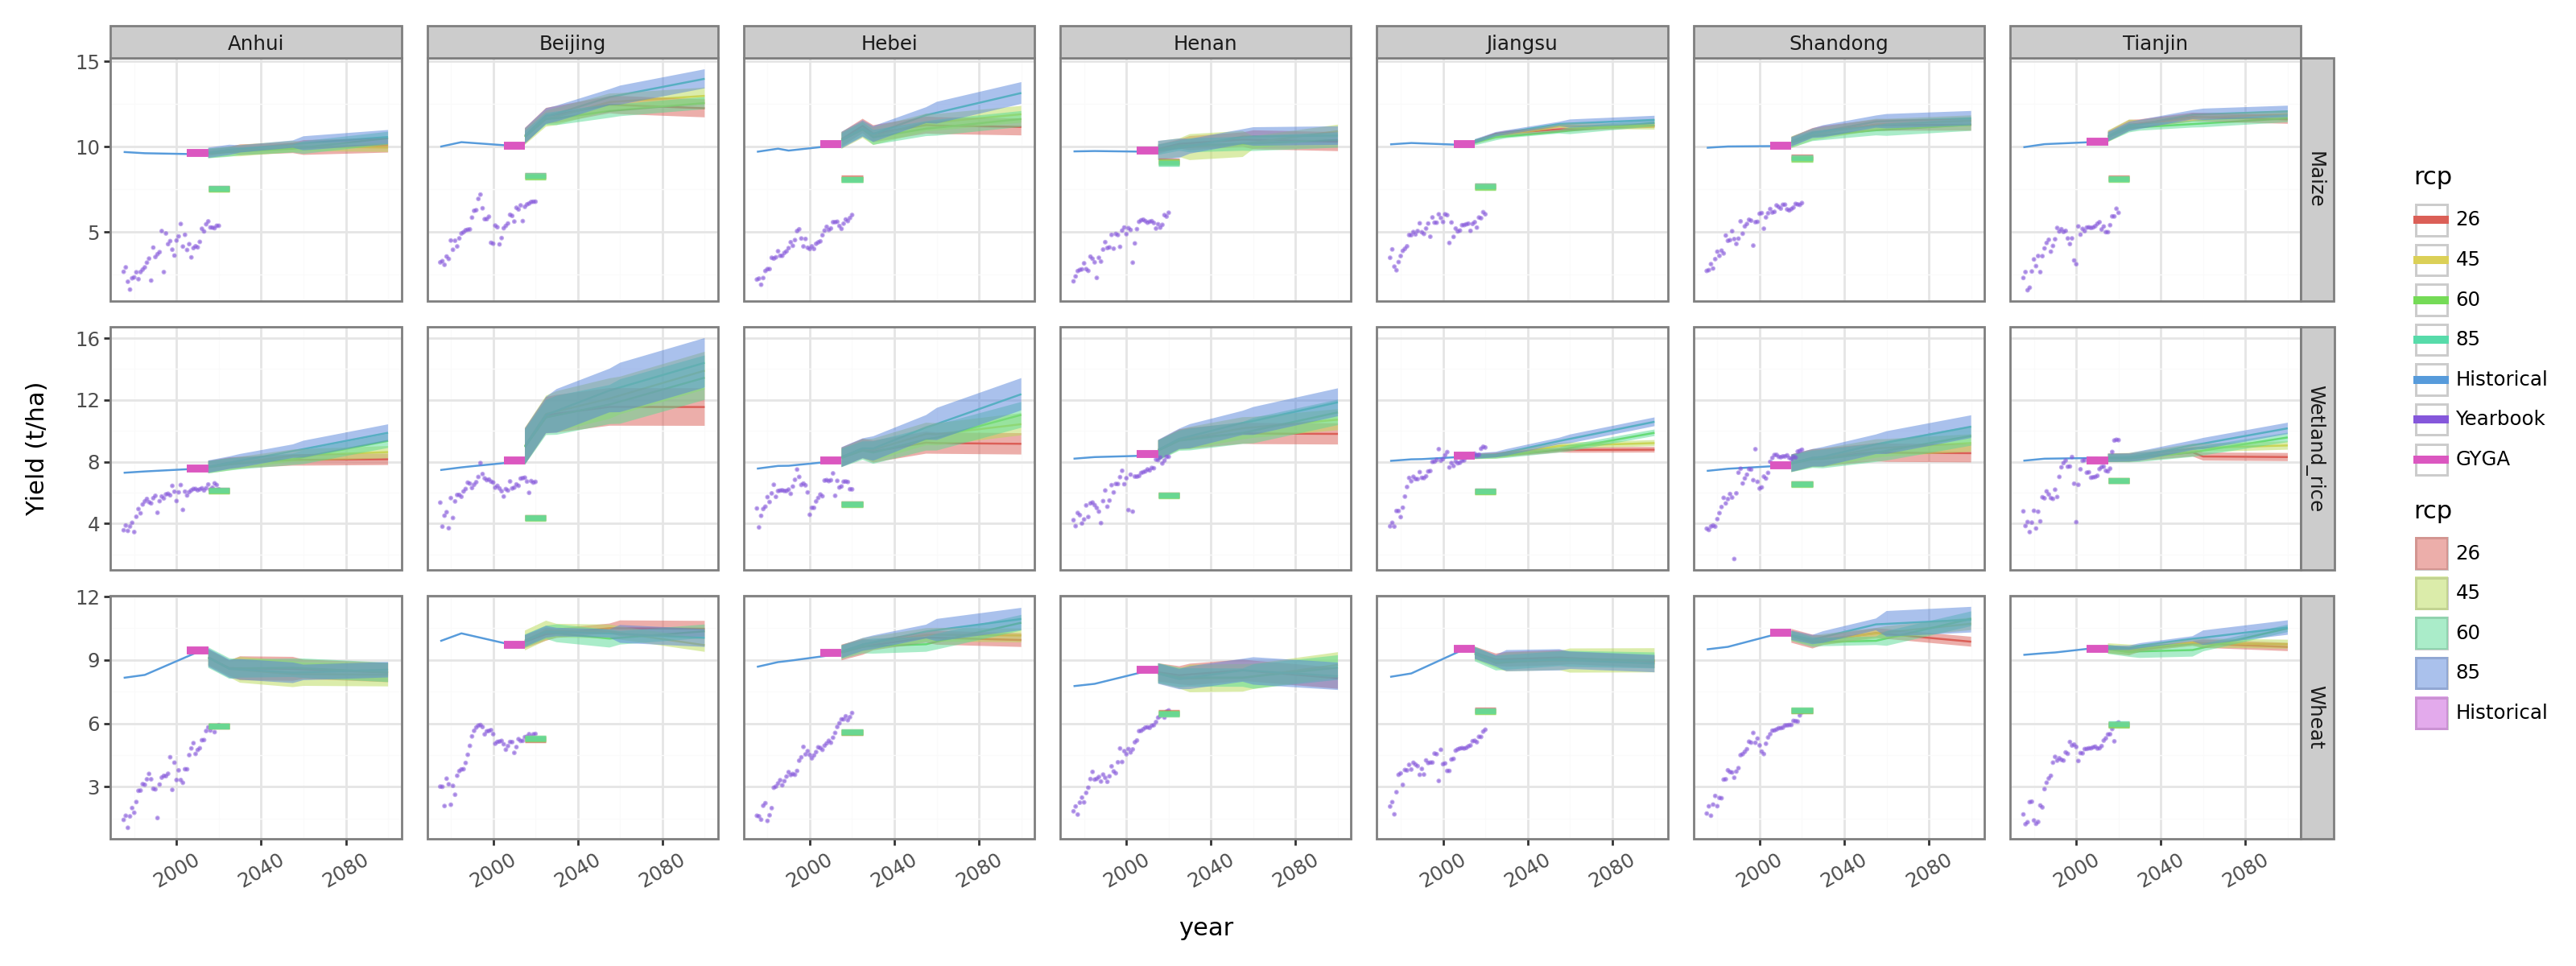

In [31]:
# plot the GAEZ/Yearbook data
plotnine.options.figure_size = (16, 6)
plotnine.options.dpi = 100

(ggplot() +
 # GAEZ attainable yiel
 geom_line(GAEZ_attainable_t_ha_forced_with_GYGA_weighted_mean_mul, aes('year','Mean Production',color='rcp')) +
 geom_ribbon(GAEZ_attainable_t_ha_forced_with_GYGA_weighted_mean_mul, aes(x='year',ymax='top',ymin='bot',fill='rcp'),alpha=0.5) +
 # yearbook history
 geom_point(crop_yield_history_1975_2020, aes('year','Mean Production',color='rcp'),alpha=0.5,size=0.2) +
 # GYGA attainable
 geom_line(GYGA_weighted_by_area_ratio, aes('year','Mean Production',color='rcp'),size=2) +
 # GAEZ_2010 yield
 geom_line(GAEZ_yield_2020_area_weighted_mean_each_province_for_plot, aes('year','Mean Production',color='rcp'),size=1.5,alpha=0.7) +
 facet_grid('crop~Province',scales='free') +
 theme_bw() + 
 theme(axis_text_x=element_text(rotation=30)) +
 ylab('Yield (t/ha)')
)

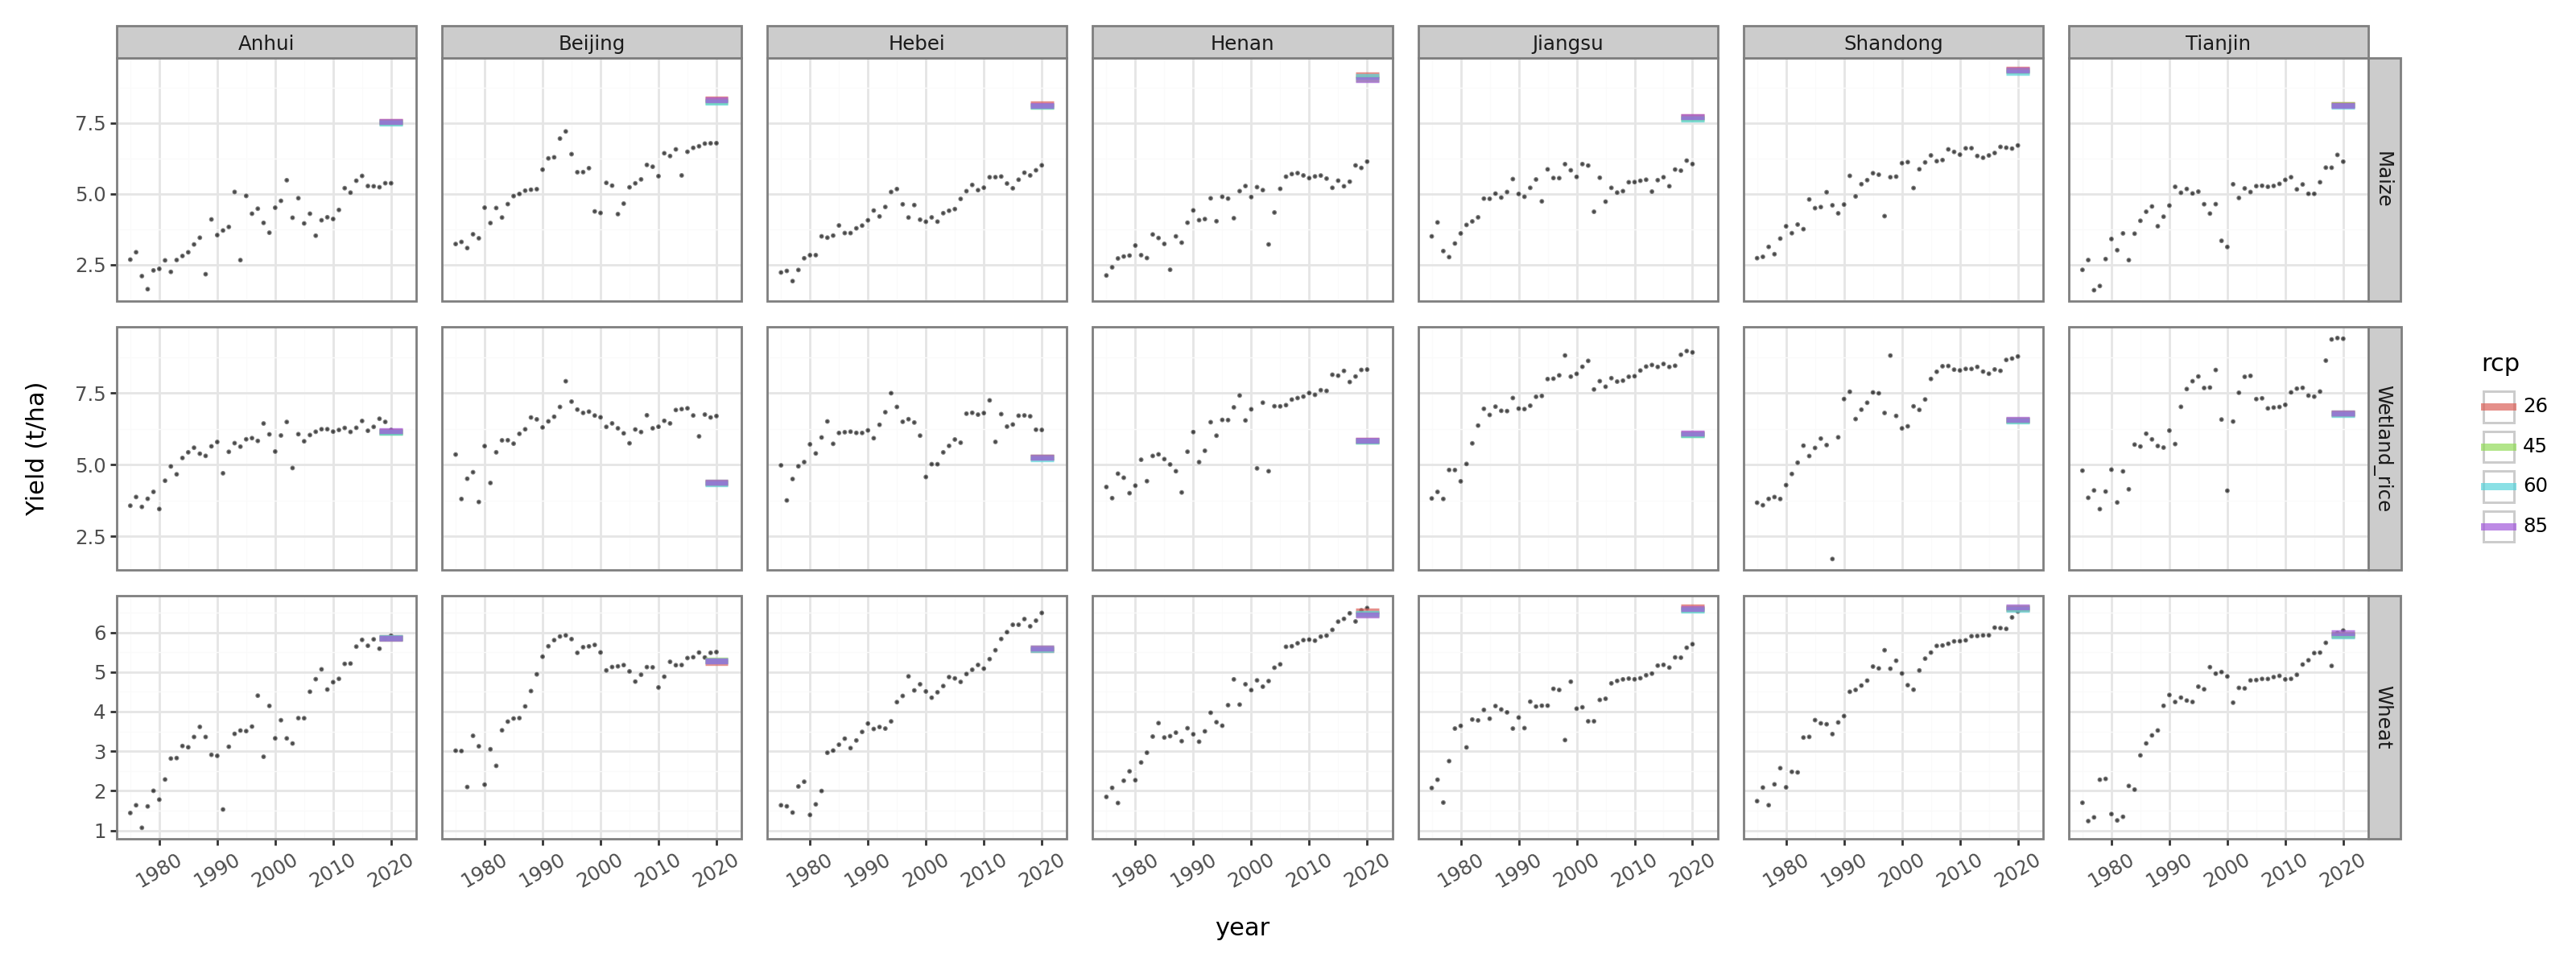

In [32]:
# data for compare GEAZ_yield and yearbook_yield
GAEZ_yield_2020_temp = GAEZ_yield_2020_area_weighted_mean_each_province_for_plot.replace({2015:2018,2025:2022})

# plot the GAEZ/Yearbook data
plotnine.options.figure_size = (16, 6)
plotnine.options.dpi = 100

g = (ggplot() +
 # yearbook history
 geom_point(crop_yield_history_1975_2020, aes('year','Mean Production'),alpha=0.5,size=0.2) +
 # GAEZ_2010 yield
 geom_line(GAEZ_yield_2020_temp, aes('year','Mean Production',color='rcp'),size=1.5,alpha=0.7) +
 facet_grid('crop~Province',scales='free') +
 theme_bw() + 
 theme(axis_text_x=element_text(rotation=30)) +
 ylab('Yield (t/ha)')
)

g

In [ ]:
# g.save('/content/sup_11_compare_yield_2010_between_GAEZ_yearbook.svg')

/usr/local/lib/python3.7/dist-packages/plotnine/ggplot.py:721: PlotnineWarning: Saving 16 x 6 in image.
/usr/local/lib/python3.7/dist-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: /content/sup_11_compare_yield_2010_between_GAEZ_yearbook.svg


#### Force GAEZ_actual_yield_2020 to agree with yearbook_2020

In [44]:
# filter the 2010 records
crop_yield_history_2020 = crop_yield_history_1975_2020[crop_yield_history_1975_2020['year']==2020]

# merge GAEZ to yearbook
yield_yearbook_GAEZ_2020 = crop_yield_history_2020.merge(GAEZ_yield_2020_area_weighted_mean_each_province,on=['crop','Province'])

yield_yearbook_GAEZ_2020['yearbook_GAEZ_delta'] = yield_yearbook_GAEZ_2020['Mean Production_x'] - yield_yearbook_GAEZ_2020['Mean Production_y']
yield_yearbook_GAEZ_2020_delta = yield_yearbook_GAEZ_2020[['rcp_y','crop','Province','yearbook_GAEZ_delta']]
yield_yearbook_GAEZ_2020_delta = yield_yearbook_GAEZ_2020_delta.rename(columns={'rcp_y':'rcp'})

In [57]:
# create the delta img for each province
delta_mosaics = {}
for idx,df in yield_yearbook_GAEZ_2020_delta.groupby(['rcp','crop']):
  rcp,crop = idx
  province_delta_dict = zip(df['Province'],df['yearbook_GAEZ_delta'])

  shps = []
  for province,val in province_delta_dict:
    shp = NCP_provinces.filterMetadata('EN_Name','equals',province).first()
    shp = shp.set('rcp',rcp,'crop',crop,'Name',province,'delta',val)
    shps.append(shp)

  fe_col = ee.FeatureCollection(shps)

  delta_mosaics[idx] = [ee.Image(0).toFloat().paint(featureCollection=fe_col, color='delta')]

# get the mosaiced imgs
delta_mosiac_img = pd.DataFrame(delta_mosaics).T.reset_index()
delta_mosiac_img.columns = ['rcp','crop','delta_img']

In [65]:
# add the delta_img to GAEZ_attainable_2010
GAEZ_actual_forced_with_Yearbook = GAEZ_attainable_t_ha_forced_with_GYGA_2020.merge(delta_mosiac_img,on=['rcp','crop'])
GAEZ_actual_forced_with_Yearbook['image'] = GAEZ_actual_forced_with_Yearbook.apply(lambda row:row['image'].add(row['delta_img']),1)

GAEZ_actual_forced_with_Yearbook = GAEZ_actual_forced_with_Yearbook.drop(columns='delta_img')
GAEZ_actual_forced_with_Yearbook.to_pickle('./result_csv/GAEZ_actual_forced_with_Yearbook.pkl')

In [66]:
GAEZ_actual_forced_with_Yearbook

,image,img_future_sd,crop,water,year,rcp,image_add,image_mul
0,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...",Maize,Irrigated,2020,26,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
1,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...",Maize,Irrigated,2020,45,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
2,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...",Maize,Irrigated,2020,60,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
3,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...",Maize,Irrigated,2020,85,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
4,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...",Maize,Rainfed,2020,26,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
5,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...",Maize,Rainfed,2020,45,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
6,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...",Maize,Rainfed,2020,60,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
7,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...",Maize,Rainfed,2020,85,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
8,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...",Wetland_rice,Irrigated,2020,26,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
9,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...",Wetland_rice,Irrigated,2020,45,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."


#### Check if the forcement is successful

In [67]:
# 1) first get area_weighted mean attainable yield (t/ha)
GAEZ_yield_2020_area_weighted_mean_add_delta = compute_area_weighted_mean(GAEZ_actual_forced_with_Yearbook)

# 2) then get mean attainable yield (t/ha) in each province
GAEZ_actual_forced_with_Yearbook_weighted_mean = parallelize_dataframe(GAEZ_yield_2020_area_weighted_mean_add_delta,compute_yield_each_province,3)

# 3) extend the year column for plot making
GAEZ_actual_forced_with_Yearbook_weighted_mean_for_plot = GAEZ_actual_forced_with_Yearbook_weighted_mean.copy()
GAEZ_actual_forced_with_Yearbook_weighted_mean_for_plot['year'] = [[2015,2025]]*len(GAEZ_actual_forced_with_Yearbook_weighted_mean)

GAEZ_actual_forced_with_Yearbook_weighted_mean_for_plot = GAEZ_actual_forced_with_Yearbook_weighted_mean_for_plot.explode('year')
GAEZ_actual_forced_with_Yearbook_weighted_mean_for_plot['year'] = GAEZ_actual_forced_with_Yearbook_weighted_mean_for_plot['year'].astype('int')

GAEZ_actual_forced_with_Yearbook_weighted_mean_for_plot.to_csv('./result_csv/GAEZ_actual_forced_with_Yearbook_weighted_mean_for_plot.csv',index=False)

c:\Users\Jinzhu\miniconda3\envs\gee\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

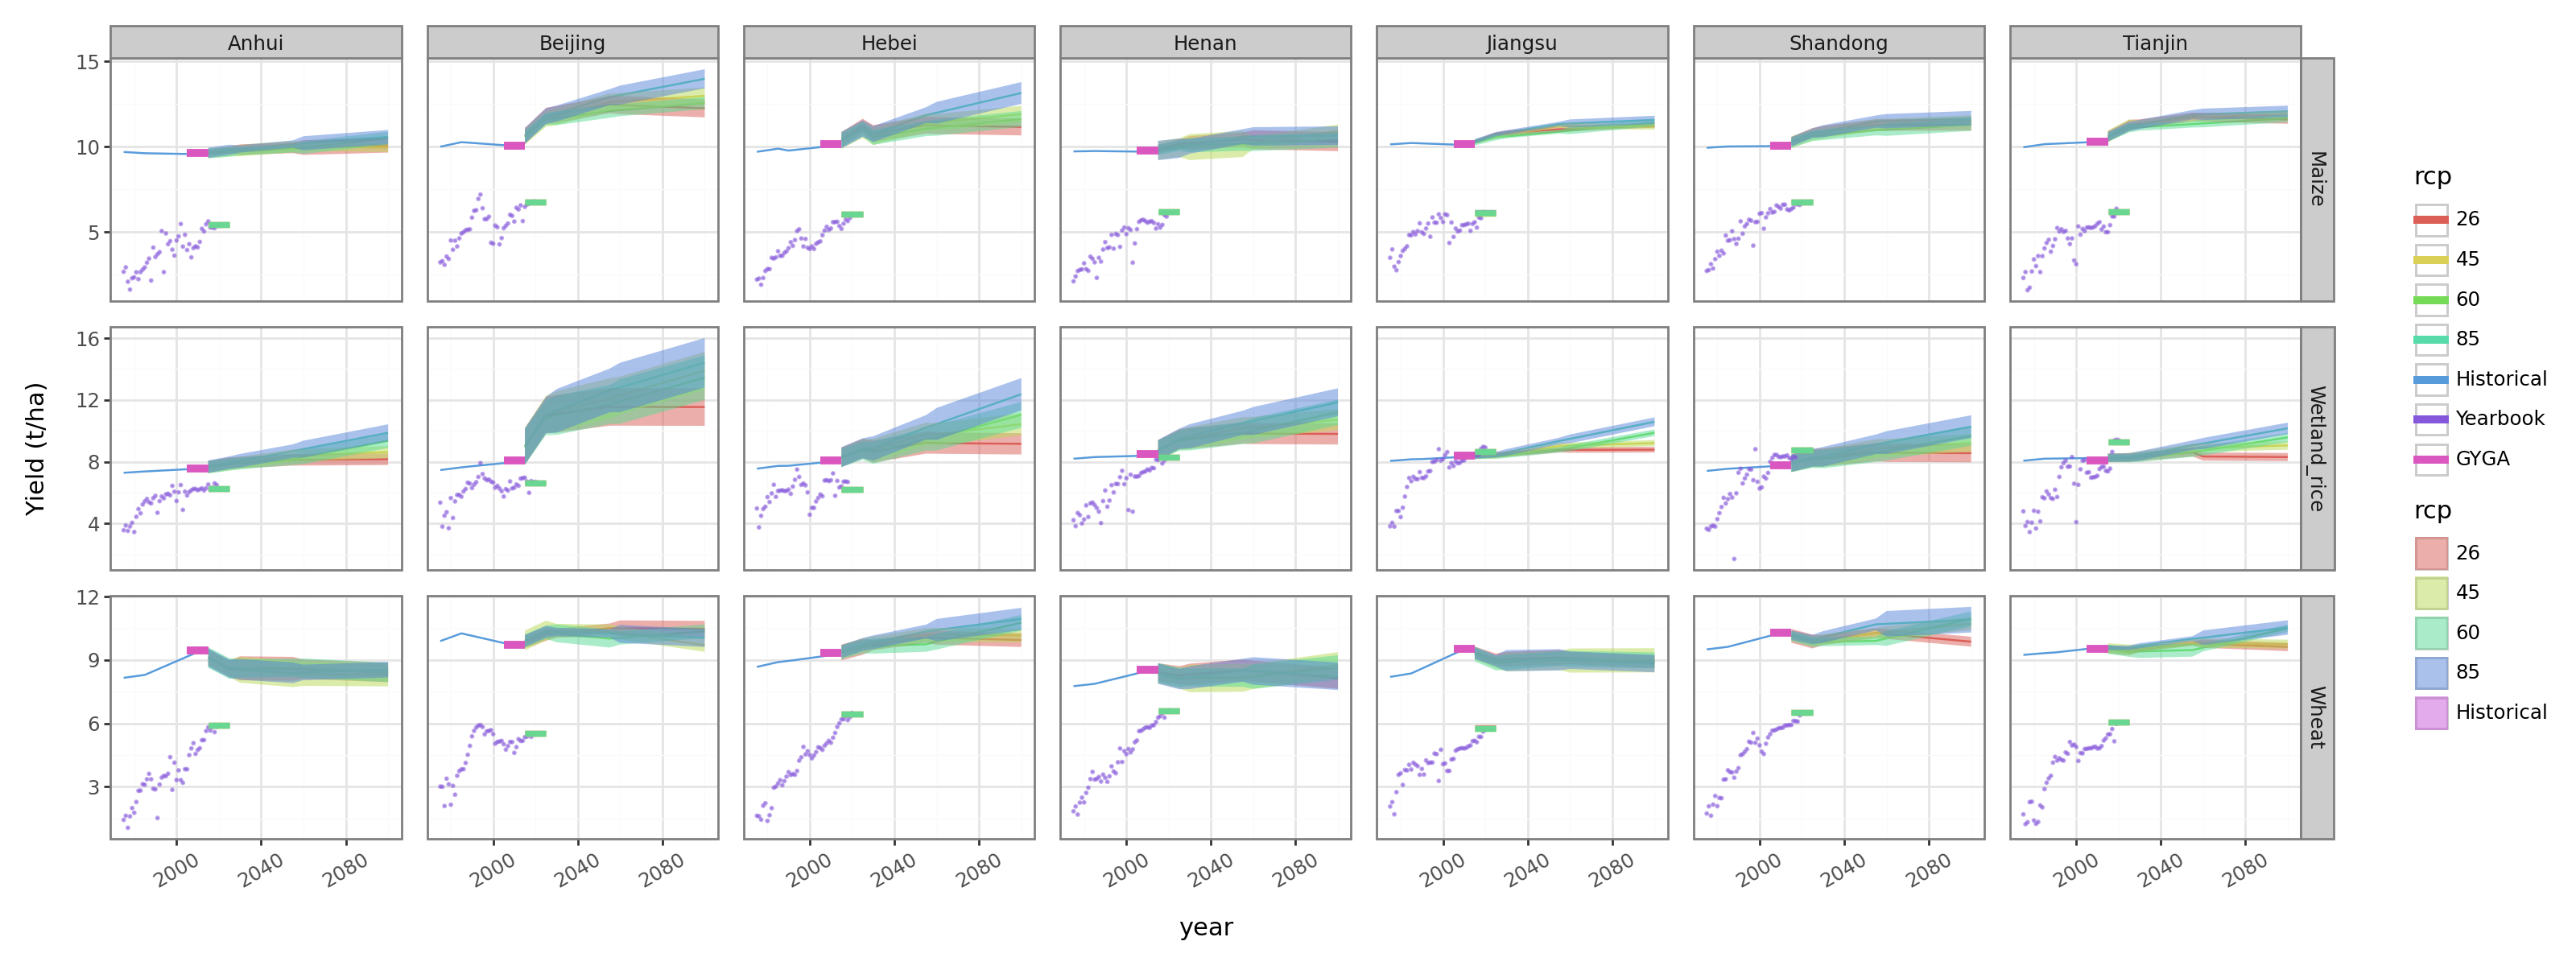

In [68]:
# plot the GAEZ/Yearbook data
plotnine.options.figure_size = (16, 6)
plotnine.options.dpi = 100

(ggplot() +
 geom_line(GAEZ_attainable_t_ha_forced_with_GYGA_weighted_mean_mul, aes('year','Mean Production',color='rcp')) +
 geom_ribbon(GAEZ_attainable_t_ha_forced_with_GYGA_weighted_mean_mul, aes(x='year',ymax='top',ymin='bot',fill='rcp'),alpha=0.5) +
 geom_point(crop_yield_history_1975_2020, aes('year','Mean Production',color='rcp'),alpha=0.5,size=0.2) +
 geom_line(GYGA_weighted_by_area_ratio, aes('year','Mean Production',color='rcp'),size=2) +
 geom_line(GAEZ_actual_forced_with_Yearbook_weighted_mean_for_plot, aes('year','Mean Production',color='rcp'),size=1.5,alpha=0.7) +
 facet_grid('crop~Province',scales='free') +
 theme_bw() + 
 theme(axis_text_x=element_text(rotation=30)) +
 ylab('Yield (t/ha)')
)